In [ ]:
import os
import pandas as pd

edges = pd.read_csv(os.path.join(os.pardir, 'data', 'edgelist.txt'), sep='\t').rename(columns={'1001': 'src', '9304045': 'trg'})
edges.head()

In [ ]:
import sys
scripts_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'scripts')
if not scripts_dir in sys.path:
    sys.path.append(scripts_dir)

In [ ]:
import networkx as nx
from get_graph import get_digraph

g: nx.DiGraph = get_digraph()

In [ ]:
import dgl

G = dgl.from_networkx(g)

In [ ]:
import numpy as np
word_embs = np.load(os.path.join(os.pardir, 'embeddings.npy'))

In [ ]:
import torch
G.ndata['word_embs'] = torch.from_numpy(np.vstack([word_embs, np.zeros((len(g.nodes()) - len(word_embs), 50))])).float()

In [ ]:
from train_test_split import make_split

adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false = make_split(nx.to_scipy_sparse_array(g))

In [120]:
train = torch.cat([torch.as_tensor(train_edges), torch.as_tensor(train_edges_false)])

train_u = train[:, 0]
train_v = train[:, 1]
train_label = torch.cat([torch.ones(len(train_edges)), torch.zeros(len(train_edges_false))])

In [121]:
test = torch.cat([torch.as_tensor(test_edges), torch.as_tensor(test_edges_false)])

test_u = test[:, 0]
test_v = test[:, 1]
test_label = torch.cat([torch.ones(len(test_edges)), torch.zeros(len(test_edges_false))])

In [122]:
val = torch.cat([torch.as_tensor(val_edges), torch.as_tensor(val_edges_false)])

val_u = val[:, 0]
val_v = val[:, 1]
val_label = torch.cat([torch.ones(len(val_edges)), torch.zeros(len(val_edges_false))])

In [123]:
from gat import GraphSAGE

net = GraphSAGE(50, 128)

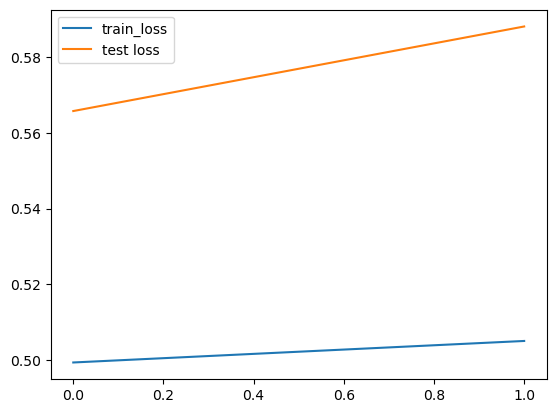

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

train_losses = []
test_losses = []


for e in range(10):
    logits = net(G, G.ndata['word_embs'].float())
    pred = torch.sigmoid((logits[train_u] * logits[train_v]).sum(dim=1))
    train_loss = F.binary_cross_entropy(pred, train_label)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        test_pred = torch.sigmoid((logits[test_u] * logits[test_v]).sum(dim=1))
        test_loss = F.binary_cross_entropy(test_pred, test_label)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    
    clear_output(True)
    plt.plot(train_losses, label='train_loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.show()

    if e % 5 == 0:
        print(f'Epoch {e}, Training Loss: {train_loss.item()}, Test Loss: {test_loss.item()}')


In [ ]:
pred = torch.sigmoid((logits[val_u] * logits[val_v]).sum(dim=1))
print('Accuracy', ((pred >= 0.5) == val_label).sum().item() / len(pred))

Accuracy 0.5063701923076923
